<a href="https://colab.research.google.com/github/Aratrika-cs/Foundations-of-Graphical-Models-STCS-GR6701-2020/blob/main/Study_of_Convergence_of_VAEs_(Graphical_Models_Final_Project)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colaboratory is an online computing platform with fast free GPUs by Google

# Loading Google Drive for saving and storing computations and diagrams
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Helper function for creating directories for saving and storing computations/diagrams
import os

def make_dir_if_not_exists(save_file):
  """Utility function for creating necessary dictories for a specified filename.
  Parameters
  ----------
  save_file : :obj:`str`
      absolute path of save file
  """
  save_dir = os.path.dirname(save_file)
  if not os.path.exists(save_dir):
      os.makedirs(save_dir)

make_dir_if_not_exists("/content/drive/My Drive/Final PGM Project/")
%cd /content/drive/My Drive/Final PGM Project/
%pwd

/content/drive/My Drive/Final PGM Project


'/content/drive/My Drive/Final PGM Project'

In [ ]:
# Defining VAE class for computing accumulated ELBO loss and accumulated sum of entropies,
# and comparing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear , Module , Parameter
from torch.nn.functional import softplus
from torch.distributions import Normal , kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
import math
import numpy as np
pi = torch.Tensor([math.pi])

# noise_std, sigma : common learnt sd of the conditional distribution of x given z ie. p(x|z), and its transformed elementwise softplus value respectively
# q_z_std, tau: Learnt Diagonal covariance matrix for q(z|x) , and its transformed elementwise softplus value respectively
# num_samples: No. of samples generated to estimate E(log(p(x|z))) under q(z|x)
# q_z: q(z|x), Variational distribution
# p_z: p(z),  prior on latent space of dimension H
# H: Latent space dimension
# D: Input and Output space dimension

class  LinearVAE(Module):
  def  __init__(self , H, D, device, num_samples = 100):
    super(LinearVAE , self).__init__ ()
    self.H = H
    self.D = D
    self.num_samples = num_samples

    self.encoder = Linear(D, H)
    self.decoder = Linear(H, D)
    self.noise_std = Parameter(torch.Tensor ([0.]))
    # self.noise_std = Parameter(torch.Tensor ([0.]).to(device))
    self.q_z_std = Parameter(torch.zeros(H))
    # self.q_z_std = Parameter(torch.zeros(H).to(device))
    # self.p_z = Normal(torch.Tensor([0.]) , torch.Tensor([1.]))
    self.p_z = Normal(torch.Tensor([0.]).to(device) , torch.Tensor([1.]).to(device))
    
  def  forward(self , x):

    sigma = softplus(self.noise_std)
    # sigma = softplus(self.noise_std).to(device)
    tau = softplus(self.q_z_std)
    # tau = softplus(self.q_z_std).to(device)
    N, D = x.shape
    # N = Parameter(torch.Tensor([N])).to(device)
    # D = Parameter(torch.Tensor([D])).to(device)
    z_params = self.encoder(x)
    # z_params = self.encoder(x).to(device)
    
    q_z = Normal(z_params.to(device) , tau.to(device))
    z_samples = q_z.rsample ([self.num_samples ])
    # z_samples = q_z.rsample ([self.num_samples ]).to(device)
    
    p_x_z_mean = self.decoder(z_samples)
    # p_x_z_mean = self.decoder(z_samples).to(device)
    p_x_z = Normal(p_x_z_mean , sigma)
    lower_bound = p_x_z.log_prob(x).mean (0).sum() - kl_divergence(q_z , self.p_z).sum()
    # lower_bound = p_x_z.log_prob(x).mean (0).sum() - 0.5*(torch.sum(z_params.pow(2))+N*(sigma**2-2*torch.log(sigma)-1))
    three_entropies_linear = self.three_entropies_linear(N, D, sigma.to(device) , tau.to(device), device=device)
    # three_entropies_linear = self.three_entropies_linear(Parameter(torch.Tensor([N])).to(device), Parameter(torch.Tensor([D])).to(device), sigma , tau)  
    
    if self.training:
      # out = p_x_z.rsample([N])
      # return  out, lower_bound, three_entropies_linear
      return -1*lower_bound, three_entropies_linear
    else:
      return p_x_z_mean, -1*lower_bound, three_entropies_linear 

  @staticmethod
  def  three_entropies_linear(N, D, sigma , tau, device):
       """ Three  Entropies (accumulated) for  linear VAE , Eq.(33).
       Args:
       N (int) : batch  size
       D (int) : output  dimensionality
       sigma (torch.tensor , size =(1,)) : decoder  standard  deviation
       tau (torch.tensor , size=(H,)     : encoder  standard  deviation
       """
       return N*(-D/2*( torch.log(2*pi.to(device))+1)-D*torch.log(sigma)+torch.log(tau).sum())

  # def  forward(self , x):
  #   sigma = softplus(self.noise_std)
  #   tau = softplus(self.q_z_std)
  #   N, D = x.shape
  #   z_params = self.encoder(x)
    
  #   q_z = Normal(z_params , tau)
  #   z_samples = q_z.rsample ([self.num_samples ])
    
  #   p_x_z_mean = self.decoder(z_samples)
  #   p_x_z = Normal(p_x_z_mean , sigma)
  #   lower_bound = p_x_z.log_prob(x).mean (0).sum() - kl_divergence(q_z , self.p_z).sum()
  #   # llk = self.loglikelihood(N, D, sigma, tau)
  #   three_entropies_linear = self.three_entropies_linear(N, D, sigma , tau)
  #   return  lower_bound , three_entropies_linear

  # def  forward(self , x):

  #   sigma = softplus(self.noise_std)
  #   # sigma = softplus(self.noise_std).to(device)
  #   tau = softplus(self.q_z_std)
  #   # tau = softplus(self.q_z_std).to(device)
  #   N, D = x.shape
  #   # N = Parameter(torch.Tensor([N])).to(device)
  #   # D = Parameter(torch.Tensor([D])).to(device)
  #   z_params = self.encoder(x).to(device)
  #   # z_params = self.encoder(x).to(device)
    
  #   q_z = Normal(z_params.to(device) , tau.to(device))
  #   z_samples = q_z.rsample ([self.num_samples ]).to(device)
  #   # z_samples = q_z.rsample ([self.num_samples ]).to(device)
    
  #   p_x_z_mean = self.decoder(z_samples)
  #   # p_x_z_mean = self.decoder(z_samples).to(device)
  #   p_x_z = Normal(p_x_z_mean , sigma)
  #   haha = p_x_z.log_prob(x).mean(0)
  #   print(type(haha))
  #   print(haha.shape)
  #   lower_bound = p_x_z.log_prob(x).mean (0).sum() - kl_divergence(q_z , self.p_z).sum()
  #   three_entropies_linear = self.three_entropies_linear(N, D, sigma.to(device) , tau.to(device), device=device)
  #   # three_entropies_linear = self.three_entropies_linear(Parameter(torch.Tensor([N])).to(device), Parameter(torch.Tensor([D])).to(device), sigma , tau)


  # def  forward(self , x):

  #   sigma = softplus(self.noise_std)
  #   # sigma = softplus(self.noise_std).to(device)
  #   tau = softplus(self.q_z_std)
  #   # tau = softplus(self.q_z_std).to(device)
  #   N, D = x.shape
  #   # N = Parameter(torch.Tensor([N])).to(device)
  #   # D = Parameter(torch.Tensor([D])).to(device)
  #   z_params = self.encoder(x)
  #   # z_params = self.encoder(x).to(device)
    
  #   q_z = Normal(z_params.to(device) , tau.to(device))
  #   z_samples = q_z.rsample ([self.num_samples ])
  #   # z_samples = q_z.rsample ([self.num_samples ]).to(device)
    
  #   p_x_z_mean = self.decoder(z_samples)
  #   # p_x_z_mean = self.decoder(z_samples).to(device)
  #   p_x_z = Normal(p_x_z_mean , sigma)
  #   lower_bound = p_x_z.log_prob(x).mean(0).mean() - kl_divergence(q_z , self.p_z).mean()
  #   three_entropies_linear = self.three_entropies_linear(N, D, sigma.to(device) , tau.to(device), device=device)
  #   # three_entropies_linear = self.three_entropies_linear(Parameter(torch.Tensor([N])).to(device), Parameter(torch.Tensor([D])).to(device), sigma , tau) 

  # @staticmethod
  # def loglikelihood(N, D, sigma , tau):
  #      """ Loglikelihood (accumulated) for  linear VAE and p-PCA , Eq.(44).
  #      Args:
  #      N (int) : batch  size
  #      D (int) : output  dimensionality
  #      sigma (torch.tensor , size =(1,)) : decoder  standard  deviation
  #      tau (torch.tensor , size=(H,)     : encoder  standard  deviation
  #      """
  #      return N*(-D/2*( torch.log(2*pi)+1)-D*torch.log(sigma)+torch.log(tau).sum())

# loglikelihood on training data based on learnt parameters
# log-likelihood on test data (held-out data) based on learnt parameters

# True log-likelihood for the training data (ground truth)
def loglikelihood(N, D, sigma=1 , tau= torch.diag(torch.ones(1)*0.1)):
  """ Loglikelihood (accumulated) for  linear VAE and p-PCA , Eq.(44).
  Args:
  N (int) : Number of observations
  D (int) : output  dimensionality
  sigma (torch.tensor , size =(1,)) : true  standard  deviation
  tau (torch.tensor , size=(H,)     : encoder  standard  deviation
  """
  return N*(-D/2*( torch.log(2*pi)+1)-D*torch.log(sigma)+torch.log(tau).sum())


In [ ]:
# Defining VAE class for computing average ELBO loss and average sum of entropies, and comparing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear , Module , Parameter
from torch.nn.functional import softplus
from torch.distributions import Normal , kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
import math
import numpy as np
pi = torch.Tensor([math.pi])

# noise_std, sigma : common learnt sd of the conditional distribution of x given z ie. p(x|z), and its transformed elementwise softplus value respectively
# q_z_std, tau: Learnt Diagonal covariance matrix for q(z|x) , and its transformed elementwise softplus value respectively
# num_samples: No. of samples generated to estimate E(log(p(x|z))) under q(z|x)
# q_z: q(z|x), Variational distribution
# p_z: p(z),  prior on latent space of dimension H
# H: Latent space dimension
# D: Input and Output space dimension

class  LinearVAE2(Module):
  def  __init__(self , H, D, device, num_samples = 100):
    super(LinearVAE2 , self).__init__ ()
    self.H = H
    self.D = D
    self.num_samples = num_samples
    self.device = device 
    self.encoder = Linear(D, H)
    self.decoder = Linear(H, D)
    self.noise_std = Parameter(torch.Tensor ([0.]))
    # self.noise_std = Parameter(torch.Tensor ([0.]).to(device))
    self.q_z_std = Parameter(torch.zeros(H))
    # self.q_z_std = Parameter(torch.zeros(H).to(device))
    # self.p_z = Normal(torch.Tensor([0.]) , torch.Tensor([1.]))
    self.p_z = Normal(torch.Tensor([0.]).to(self.device) , torch.Tensor([1.]).to(self.device))
    
  def  forward(self , x):

    sigma = softplus(self.noise_std)
    # sigma = softplus(self.noise_std).to(device)
    tau = softplus(self.q_z_std)
    # tau = softplus(self.q_z_std).to(device)
    N, D = x.shape
    # N = Parameter(torch.Tensor([N])).to(device)
    # D = Parameter(torch.Tensor([D])).to(device)
    z_params = self.encoder(x)
    # z_params = self.encoder(x).to(device)
    
    q_z = Normal(z_params.to(self.device) , tau.to(self.device))
    z_samples = q_z.rsample ([self.num_samples ])
    # z_samples = q_z.rsample ([self.num_samples ]).to(device)
    
    p_x_z_mean = self.decoder(z_samples)
    # p_x_z_mean = self.decoder(z_samples).to(device)
    p_x_z = Normal(p_x_z_mean , sigma)
    lower_bound = D * p_x_z.log_prob(x).mean() - kl_divergence(q_z , self.p_z).mean()
    # lower_bound = p_x_z.log_prob(x).mean (0).sum() - 0.5*(torch.sum(z_params.pow(2))+N*(sigma**2-2*torch.log(sigma)-1))
    three_entropies_linear = self.three_entropies_linear(N, D, sigma.to(self.device) , tau.to(self.device), device=self.device)
    # three_entropies_linear = self.three_entropies_linear(Parameter(torch.Tensor([N])).to(device), Parameter(torch.Tensor([D])).to(device), sigma , tau)  

    if self.training:
      # out = p_x_z.rsample([N])
      # return  out, lower_bound, three_entropies_linear
      return -1*lower_bound, three_entropies_linear
    else:
      return p_x_z_mean, -1*lower_bound, three_entropies_linear 

  @staticmethod
  def  three_entropies_linear(N, D, sigma , tau, device):
       """ Three  Entropies (accumulated) for  linear VAE , Eq.(33).
       Args:
       N (int) : batch  size
       D (int) : output  dimensionality
       sigma (torch.tensor , size =(1,)) : decoder  standard  deviation
       tau (torch.tensor , size=(H,)     : encoder  standard  deviation
       """
       return -D/2*( torch.log(2*pi.to(device))+1)-D*torch.log(sigma)+torch.log(tau).sum()


  # def  forward(self , x):

  #   sigma = softplus(self.noise_std)
  #   # sigma = softplus(self.noise_std).to(device)
  #   tau = softplus(self.q_z_std)
  #   # tau = softplus(self.q_z_std).to(device)
  #   N, D = x.shape
  #   # N = Parameter(torch.Tensor([N])).to(device)
  #   # D = Parameter(torch.Tensor([D])).to(device)
  #   z_params = self.encoder(x)
  #   # z_params = self.encoder(x).to(device)
    
  #   q_z = Normal(z_params.to(device) , tau.to(device))
  #   z_samples = q_z.rsample ([self.num_samples ])
  #   # z_samples = q_z.rsample ([self.num_samples ]).to(device)
    
  #   p_x_z_mean = self.decoder(z_samples)
  #   # p_x_z_mean = self.decoder(z_samples).to(device)
  #   p_x_z = Normal(p_x_z_mean , sigma)
  #   lower_bound = p_x_z.log_prob(x).mean(0).mean() - kl_divergence(q_z , self.p_z).mean()
  #   three_entropies_linear = self.three_entropies_linear(N, D, sigma.to(device) , tau.to(device), device=device)
  #   # three_entropies_linear = self.three_entropies_linear(Parameter(torch.Tensor([N])).to(device), Parameter(torch.Tensor([D])).to(device), sigma , tau) 

    # def  forward(self , x):
  #   sigma = softplus(self.noise_std)
  #   tau = softplus(self.q_z_std)
  #   N, D = x.shape
  #   z_params = self.encoder(x)
    
  #   q_z = Normal(z_params , tau)
  #   z_samples = q_z.rsample ([self.num_samples ])
    
  #   p_x_z_mean = self.decoder(z_samples)
  #   p_x_z = Normal(p_x_z_mean , sigma)
  #   lower_bound = p_x_z.log_prob(x).mean (0).sum() - kl_divergence(q_z , self.p_z).sum()
  #   # llk = self.loglikelihood(N, D, sigma, tau)
  #   three_entropies_linear = self.three_entropies_linear(N, D, sigma , tau)
  #   return  lower_bound , three_entropies_linear

  # def  forward(self , x):

  #   sigma = softplus(self.noise_std)
  #   # sigma = softplus(self.noise_std).to(device)
  #   tau = softplus(self.q_z_std)
  #   # tau = softplus(self.q_z_std).to(device)
  #   N, D = x.shape
  #   # N = Parameter(torch.Tensor([N])).to(device)
  #   # D = Parameter(torch.Tensor([D])).to(device)
  #   z_params = self.encoder(x).to(device)
  #   # z_params = self.encoder(x).to(device)
    
  #   q_z = Normal(z_params.to(device) , tau.to(device))
  #   z_samples = q_z.rsample ([self.num_samples ]).to(device)
  #   # z_samples = q_z.rsample ([self.num_samples ]).to(device)
    
  #   p_x_z_mean = self.decoder(z_samples)
  #   # p_x_z_mean = self.decoder(z_samples).to(device)
  #   p_x_z = Normal(p_x_z_mean , sigma)
  #   haha = p_x_z.log_prob(x).mean(0)
  #   print(type(haha))
  #   print(haha.shape)
  #   lower_bound = p_x_z.log_prob(x).mean (0).sum() - kl_divergence(q_z , self.p_z).sum()
  #   three_entropies_linear = self.three_entropies_linear(N, D, sigma.to(device) , tau.to(device), device=device)
  #   # three_entropies_linear = self.three_entropies_linear(Parameter(torch.Tensor([N])).to(device), Parameter(torch.Tensor([D])).to(device), sigma , tau)

  # @staticmethod
  # def loglikelihood(N, D, sigma , tau):
  #      """ Loglikelihood (accumulated) for  linear VAE and p-PCA , Eq.(44).
  #      Args:
  #      N (int) : batch  size
  #      D (int) : output  dimensionality
  #      sigma (torch.tensor , size =(1,)) : decoder  standard  deviation
  #      tau (torch.tensor , size=(H,)     : encoder  standard  deviation
  #      """
  #      return N*(-D/2*( torch.log(2*pi)+1)-D*torch.log(sigma)+torch.log(tau).sum())

# loglikelihood on training data based on learnt parameters
# log-likelihood on test data (held-out data) based on learnt parameters

# True log-likelihood for the training data (ground truth)
def loglikelihood(N, D, sigma=1 , tau= torch.diag(torch.ones(1)*0.1)):
  """ Loglikelihood (accumulated) for  linear VAE and p-PCA , Eq.(44).
  Args:
  N (int) : Number of observations
  D (int) : output  dimensionality
  sigma (torch.tensor , size =(1,)) : true  standard  deviation
  tau (torch.tensor , size=(H,)     : encoder  standard  deviation
  """
  return N*(-D/2*( torch.log(2*pi)+1)-D*torch.log(sigma)+torch.log(tau).sum())


In [ ]:
# PCA data set generation 

def gen_PCA_dataset(n_train= 10000,n_test= 10000,D=10,H=1,sigma_gen=0.1,seed=0):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(seed)
    p_z_cov_mat = torch.eye(H).to(device)
    p_z_mean = torch.rand(H).to(device)
    p_z = mvn(p_z_mean, p_z_cov_mat)
    z_train =  p_z.rsample(torch.Size([n_train])).to(device)
    z_test =  p_z.rsample(torch.Size([n_test])).to(device)
    p_x_z_W = torch.rand(D,H).to(device)
    p_x_z_mu = torch.rand(H).to(device)
    p_x_z_mean= torch.einsum('hw,w->h',p_x_z_W,p_x_z_mu).to(device)
    p_x_z_cov_mat = (torch.eye(D)*sigma_gen).to(device)
    p_x_z = mvn(p_x_z_mean, p_x_z_cov_mat)
    x_z_train = p_x_z.rsample(torch.Size([n_train])).to(device)
    x_z_test = p_x_z.rsample(torch.Size([n_test])).to(device)

    return x_z_train, x_z_test

x_train, x_test  = gen_PCA_dataset()

torch.save(x_train, "/content/drive/My Drive/Final PGM Project/PCA_training_data_25multiplerun")
torch.save(x_test,"/content/drive/My Drive/Final PGM Project/PCA_test_data_25multiplerun")

# def gen_PCA_dataset(n_train= 10000,n_test= 10000,runs=100,D=10,H=1,sigma_gen=0.1,seed=0):
#     torch.seed(seed)
#     device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
#     p_z_cov_mat = torch.eye(H).to()
#     p_z_mean = torch.rand(runs,H)
#     p_z = mvn(p_z_mean, p_z_cov_mat)
#     z_train =  p_z.rsample(torch.Size([n_train]))
#     z_test =  p_z.rsample(torch.Size([n_test]))
#     p_x_z_W = torch.rand(runs,D,H)
#     p_x_z_mu = torch.rand(runs,H)
#     p_x_z_mean= torch.einsum('nhw,nw->nh',p_x_z_W,p_x_z_mu)
#     p_x_z_cov_mat = torch.eye(D)*sigma_gen
#     p_x_z = mvn(p_x_z_mean, p_x_z_cov_mat)
#     x_z_train = p_x_z.rsample(torch.Size([n_train]))
#     x_z_test = p_x_z.rsample(torch.Size([n_test]))

#     return x_z_train, x_z_test

In [ ]:
# Single run testing
# Computing accumulated ELBO loss and accumulated Sum of entropies 

# Parameters
D = 10
H = 1
batch_size = 2000
lr = 10**(-3)
num_epochs = 1500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setting seed for reproducibility
torch.manual_seed(0)

# Initializing
Lin_VAE = LinearVAE(H, D, device, num_samples = 100)

# Transferring to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Lin_VAE = Lin_VAE.to(device)

# Setting up the Adam Optimizer
optimizer = torch.optim.Adam(params=Lin_VAE.parameters(), lr=lr)
# optimizer = torch.optim.SGD(params=Lin_VAE.parameters(), lr=lr)

# set to training mode
Lin_VAE.train()

# Determining total number of training samples and number of batches
N = x_train.size()[0]
remainder = (N%batch_size)
n_batch = (N//batch_size) + remainder

# If number of training samples not exact multiple of batch_size, setting flag to handle last batch separately
if (remainder>0):
  flag1 = True
else:
  flag1 = False

# Initializing arrays for storing the outputs
train_elboloss = np.zeros(shape=(num_epochs,n_batch+1))
train_sumentropies = np.zeros(shape=(num_epochs,n_batch+1))

# Starting the training loop
print('Training ...')
for epoch in range(num_epochs):
    # train_elboloss.append(0)
    # train_sumentropies.append(0)
    num_batches = 0
    
    for i in range(n_batch):

        if (flag1 and num_batches==(n_batch-1)):
          flag2 = True
          old_batch_size = batch_size
          batch_size = x_train[-remainder:]
        else:
          flag2 = False
          batch_data = x_train[i*batch_size:(i+1)*batch_size]

        batch_data = batch_data.to(device)

        # ELBO and entropy sum computation
        Elboloss, sumentropies = Lin_VAE(batch_data)
        
        # backpropagation
        optimizer.zero_grad()
        Elboloss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        # train_loss_avg[-1] += loss.item()
        train_elboloss[epoch,i] = Elboloss
        train_sumentropies[epoch,i] = sumentropies
        num_batches += 1

        if (flag2):
          batch_size = old_batch_size
        
    # train_loss_avg[-1] /= num_batches
    train_elboloss[epoch,n_batch] = np.sum(train_elboloss[epoch,:])
    train_sumentropies[epoch,n_batch] = np.sum(train_sumentropies[epoch,:])
    print('Epoch [%d / %d] ELBO Loss: %f Sum of Entropies: %f' % (epoch+1, num_epochs, train_elboloss[epoch,n_batch], train_sumentropies[epoch,n_batch]))

torch.save(-1*train_elboloss,"/content/drive/My Drive/Final PGM Project/train_elboloss_singlerun")
torch.save(train_sumentropies,"/content/drive/My Drive/Final PGM Project/train_sumentropies_singlerun")

Training ...
Epoch [1 / 1500] ELBO Loss: 126436.013672 Sum of Entropies: -109066.248047
Epoch [2 / 1500] ELBO Loss: 125262.324219 Sum of Entropies: -109461.074219
Epoch [3 / 1500] ELBO Loss: 124102.541016 Sum of Entropies: -109851.279297
Epoch [4 / 1500] ELBO Loss: 123041.611328 Sum of Entropies: -110234.042969
Epoch [5 / 1500] ELBO Loss: 121969.544922 Sum of Entropies: -110606.669922
Epoch [6 / 1500] ELBO Loss: 120957.685547 Sum of Entropies: -110966.593750
Epoch [7 / 1500] ELBO Loss: 120004.689453 Sum of Entropies: -111311.769531
Epoch [8 / 1500] ELBO Loss: 119059.814453 Sum of Entropies: -111640.384766
Epoch [9 / 1500] ELBO Loss: 118170.958984 Sum of Entropies: -111950.710938
Epoch [10 / 1500] ELBO Loss: 117374.689453 Sum of Entropies: -112241.558594
Epoch [11 / 1500] ELBO Loss: 116575.341797 Sum of Entropies: -112512.283203
Epoch [12 / 1500] ELBO Loss: 115758.199219 Sum of Entropies: -112761.927734
Epoch [13 / 1500] ELBO Loss: 115017.205078 Sum of Entropies: -112989.378906
Epoch [1

In [ ]:
# Single run testing
# Computing average ELBO loss and average Sum of entropies 

# Parameters
D = 10
H = 1
batch_size = 2000
lr = 10**(-3)
num_epochs = 1500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setting seed for reproducibility
torch.manual_seed(0)

# Initializing
Lin_VAE2 = LinearVAE2(H, D, device, num_samples = 100)

# Transferring to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Lin_VAE2 = Lin_VAE2.to(device)

# Setting up the Adam Optimizer
optimizer = torch.optim.Adam(params=Lin_VAE2.parameters(), lr=lr)
# optimizer = torch.optim.SGD(params=Lin_VAE.parameters(), lr=lr)

# set to training mode
Lin_VAE2.train()

# Determining total number of training samples and number of batches
N = x_train.size()[0]
remainder = (N%batch_size)
n_batch = (N//batch_size) + remainder

# If number of training samples not exact multiple of batch_size, setting flag to handle last batch separately
if (remainder>0):
  flag1 = True
else:
  flag1 = False

# Initializing arrays for storing the outputs
train_elboloss2 = np.zeros(shape=(num_epochs,n_batch+1))
train_sumentropies2 = np.zeros(shape=(num_epochs,n_batch+1))

# Starting the training loop
print('Training ...')
for epoch in range(num_epochs):
    # train_elboloss.append(0)
    # train_sumentropies.append(0)
    num_batches = 0
    
    for i in range(n_batch):

        if (flag1 and num_batches==(n_batch-1)):
          flag2 = True
          old_batch_size = batch_size
          batch_size = x_train[-remainder:]
        else:
          flag2 = False
          batch_data = x_train[i*batch_size:(i+1)*batch_size]

        batch_data = batch_data.to(device)

        # ELBO and entropy sum computation
        Elboloss2, sumentropies2 = Lin_VAE2(batch_data)
        
        # backpropagation
        optimizer.zero_grad()
        Elboloss2.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        # train_loss_avg[-1] += loss.item()
        train_elboloss2[epoch,i] = Elboloss2
        train_sumentropies2[epoch,i] = sumentropies2
        num_batches += 1

        if (flag2):
          batch_size = old_batch_size
        
    # train_loss_avg[-1] /= num_batches
    train_elboloss2[epoch,n_batch] = np.sum(train_elboloss2[epoch,:]/(n_batch))
    train_sumentropies2[epoch,n_batch] = np.sum(train_sumentropies2[epoch,:]/(n_batch))
    print('Epoch [%d / %d] ELBO Loss: %f Sum of Entropies: %f' % (epoch+1, num_epochs, train_elboloss2[epoch,n_batch], train_sumentropies2[epoch,n_batch]))

torch.save(-1*train_elboloss2,"/content/drive/My Drive/Final PGM Project/train_elboloss_singlerun_average")
torch.save(train_sumentropies2,"/content/drive/My Drive/Final PGM Project/train_sumentropies_singlerun_average")

Training ...
Epoch [1 / 1500] ELBO Loss: 12.643602 Sum of Entropies: -10.906625
Epoch [2 / 1500] ELBO Loss: 12.526233 Sum of Entropies: -10.946107
Epoch [3 / 1500] ELBO Loss: 12.410254 Sum of Entropies: -10.985128
Epoch [4 / 1500] ELBO Loss: 12.304161 Sum of Entropies: -11.023404
Epoch [5 / 1500] ELBO Loss: 12.196955 Sum of Entropies: -11.060667
Epoch [6 / 1500] ELBO Loss: 12.095769 Sum of Entropies: -11.096659
Epoch [7 / 1500] ELBO Loss: 12.000469 Sum of Entropies: -11.131177
Epoch [8 / 1500] ELBO Loss: 11.905982 Sum of Entropies: -11.164038
Epoch [9 / 1500] ELBO Loss: 11.817096 Sum of Entropies: -11.195071
Epoch [10 / 1500] ELBO Loss: 11.737469 Sum of Entropies: -11.224156
Epoch [11 / 1500] ELBO Loss: 11.657534 Sum of Entropies: -11.251228
Epoch [12 / 1500] ELBO Loss: 11.575820 Sum of Entropies: -11.276193
Epoch [13 / 1500] ELBO Loss: 11.501721 Sum of Entropies: -11.298938
Epoch [14 / 1500] ELBO Loss: 11.432502 Sum of Entropies: -11.319415
Epoch [15 / 1500] ELBO Loss: 11.362586 Sum o

In [ ]:
# Defining the function for multiple runs of the experiment

# Note: The negative ELBO converges to the linear combination of entropies.
# Hence the ELBO and the linear combination of entropies will converge to apoint where they are equal
# in magnitude but opposite in signs.

# While saving the data, we save the negative ELBO values for future use instead of the ELBO values

def Lin_VAE_multiple_runs(runs=25):
  elboloss2 = np.zeros(shape=(runs,1500,6))
  sumentropies2 = np.zeros(shape=(runs,1500,6))
  for k in range(runs):
    # Parameters
    D = 10
    H = 1
    batch_size = 2000
    lr = 10**(-3)
    num_epochs = 1500

    # Setting seed for reproducibility
    # torch.manual_seed(0)

    # Transferring to GPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Initializing
    Lin_VAE2 = LinearVAE2(H, D, device, num_samples = 100)

    Lin_VAE2 = Lin_VAE2.to(device)

    # Setting up the Adam Optimizer
    optimizer = torch.optim.Adam(params=Lin_VAE2.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(params=Lin_VAE.parameters(), lr=lr)

    # set to training mode
    Lin_VAE2.train()

    # Determining total number of training samples and number of batches
    N = x_train.size()[0]
    remainder = (N%batch_size)
    n_batch = (N//batch_size) + remainder

    # If number of training samples not exact multiple of batch_size, setting flag to handle last batch separately
    if (remainder>0):
      flag1 = True
    else:
      flag1 = False

    # Initializing arrays for storing the outputs
    # train_elboloss2 = np.zeros(shape=(num_epochs,n_batch+1))
    # train_sumentropies2 = np.zeros(shape=(num_epochs,n_batch+1))

    # Starting the training loop
    print('Training ...')
    for epoch in range(num_epochs):
        # train_elboloss.append(0)
        # train_sumentropies.append(0)
        num_batches = 0
        
        for i in range(n_batch):

            if (flag1 and num_batches==(n_batch-1)):
              flag2 = True
              old_batch_size = batch_size
              batch_size = x_train[-remainder:]
            else:
              flag2 = False
              batch_data = x_train[i*batch_size:(i+1)*batch_size]

            batch_data = batch_data.to(device)

            # vae reconstruction
            Elboloss2, sumentropy2 = Lin_VAE2(batch_data)
            
            # # reconstruction error
            # loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
            
            # backpropagation
            optimizer.zero_grad()
            Elboloss2.backward()
            
            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
            
            # train_loss_avg[-1] += loss.item()
            elboloss2[k,epoch,i] = Elboloss2
            sumentropies2[k,epoch,i] = sumentropy2
            num_batches += 1

            if (flag2):
              batch_size = old_batch_size
            
        # train_loss_avg[-1] /= num_batches
        elboloss2[k,epoch,n_batch] = np.sum(elboloss2[k,epoch,:]/(n_batch))
        sumentropies2[k,epoch,n_batch] = np.sum(sumentropies2[k,epoch,:]/(n_batch))
        print('Run [%d / %d] Epoch [%d / %d] ELBO Loss: %f Sum of Entropies: %f' % (k+1, runs, epoch+1, num_epochs, elboloss2[k,epoch,n_batch], sumentropies2[k,epoch,n_batch]))

    torch.save(-1*elboloss2[k,:,:],"/content/drive/My Drive/Final PGM Project/train_elboloss_run_"+str(k+1)+"_25singlerun_average")
    torch.save(sumentropies2[k,:,:],"/content/drive/My Drive/Final PGM Project/train_sumentropies_"+str(k+1)+"_25singlerun_average")
    np.save("/content/drive/My Drive/Final PGM Project/train_elboloss_run_"+str(k+1)+"_25singlerun_average.npy", -1*elboloss2[k,:,:])
    np.save("/content/drive/My Drive/Final PGM Project/train_sumentropies_"+str(k+1)+"_25singlerun_average.npy",sumentropies2[k,:,:])

  torch.save(-1*elboloss2,"/content/drive/My Drive/Final PGM Project/train_elboloss_25multiplerun_average")
  torch.save(sumentropies2,"/content/drive/My Drive/Final PGM Project/train_sumentropies_25multiplerun_average")
  np.save("/content/drive/My Drive/Final PGM Project/train_elboloss_25multiplerun_average.npy", -1*elboloss2)
  np.save("/content/drive/My Drive/Final PGM Project/train_sumentropies_25multiplerun_average.npy",sumentropies2)

In [ ]:
# Carrying out multiple runs
Lin_VAE_multiple_runs(runs=25)

Streaming output truncated to the last 5000 lines.
Run [22 / 25] Epoch [1004 / 1500] ELBO Loss: 2.670343 Sum of Entropies: -2.671272
Run [22 / 25] Epoch [1005 / 1500] ELBO Loss: 2.669821 Sum of Entropies: -2.671244
Run [22 / 25] Epoch [1006 / 1500] ELBO Loss: 2.670621 Sum of Entropies: -2.671190
Run [22 / 25] Epoch [1007 / 1500] ELBO Loss: 2.670482 Sum of Entropies: -2.671183
Run [22 / 25] Epoch [1008 / 1500] ELBO Loss: 2.670681 Sum of Entropies: -2.671195
Run [22 / 25] Epoch [1009 / 1500] ELBO Loss: 2.670119 Sum of Entropies: -2.671220
Run [22 / 25] Epoch [1010 / 1500] ELBO Loss: 2.670792 Sum of Entropies: -2.671206
Run [22 / 25] Epoch [1011 / 1500] ELBO Loss: 2.670112 Sum of Entropies: -2.671218
Run [22 / 25] Epoch [1012 / 1500] ELBO Loss: 2.670611 Sum of Entropies: -2.671215
Run [22 / 25] Epoch [1013 / 1500] ELBO Loss: 2.670439 Sum of Entropies: -2.671215
Run [22 / 25] Epoch [1014 / 1500] ELBO Loss: 2.670173 Sum of Entropies: -2.671208
Run [22 / 25] Epoch [1015 / 1500] ELBO Loss: 2.

In [ ]:
# Saving and storing the computed ELBO (negtaive) and entropy sum values

torch.save(-1*train_elboloss,"/content/drive/My Drive/Final PGM Project/train_elboloss_singlerun")
torch.save(train_sumentropies,"/content/drive/My Drive/Final PGM Project/train_sumentropies_singlerun")
torch.save(-1*train_elboloss2,"/content/drive/My Drive/Final PGM Project/train_elboloss_singlerun_average")
torch.save(train_sumentropies2,"/content/drive/My Drive/Final PGM Project/train_sumentropies_singlerun_average")

np.save("/content/drive/My Drive/Final PGM Project/train_elboloss_singlerun.npy",-1*train_elboloss)
np.save("/content/drive/My Drive/Final PGM Project/train_sumentropies_singlerun.npy",train_sumentropies)
np.save("/content/drive/My Drive/Final PGM Project/train_elboloss_singlerun_average.npy",-1*train_elboloss2)
np.save("/content/drive/My Drive/Final PGM Project/train_sumentropies_singlerun_average.npy",train_sumentropies2)

In [ ]:
# Loading the data on ELBO and entropy sum values for the multiple run experiment from disk
elboloss25 = torch.load("/content/drive/My Drive/Final PGM Project/train_elboloss_25multiplerun_average")
sumentropies25 = torch.load("/content/drive/My Drive/Final PGM Project/train_sumentropies_25multiplerun_average")

In [ ]:
# Computing the mean and standard deviations of the negative ELBO and
# the sum of entropies across multiple runs

elboloss_means = elboloss25[:,:,5].mean(0)
elboloss_stds = elboloss25[:,:,5].std(0)
sumentropies25_means = sumentropies25[:,:,5].mean(0)
sumentropies25_stds = sumentropies25[:,:,5].std(0)

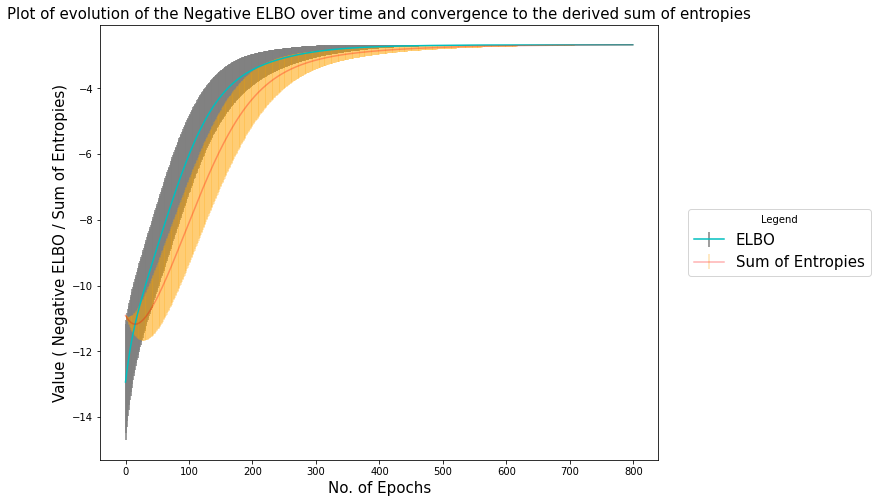

In [ ]:
# Plotting the evolution of th enegative ELBO and its comparison with the sum of entropies at every epoch
# NOTE: We allow the VAE to train for 1500 epochs within each run, but convergence is attained much earlier
# So we plot only upto 8000 epochs

# The standard error bar of +-1 sd magnitude is plotted about the mean value at each epoch
# Red curve is the average sum of entropies and the yellow band is the corresponding sd error band
# Cyan curve is the average sum of entropies and the grey band is the corresponding sd error band

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,8))
plt.errorbar(np.arange(800),elboloss_means[:800],yerr=elboloss_stds[:800],fmt='c-',ecolor='gray',label='ELBO')
plt.errorbar(np.arange(800),sumentropies25_means[:800],yerr=sumentropies25_stds[:800],fmt='r-',ecolor='orange',alpha=0.3,label='Sum of Entropies')
plt.title('Plot of evolution of the Negative ELBO over time and convergence to the derived sum of entropies',fontsize=15)
plt.xlabel('No. of Epochs',fontsize=15)
plt.ylabel('Value ( Negative ELBO / Sum of Entropies)',fontsize=15)
plt.legend(bbox_to_anchor=(1.04,0.5), title="Legend",loc="center left",prop={'size':15})
plt.savefig("ELBO convergence to sum of entropies.jpg",bbox_inches='tight')
plt.show()